In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier

D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [3]:
# Take a subset of the dataset (e.g., first 1000 samples)
subset_size = 1000
x_train_subset, y_train_subset = x_train[:subset_size] / 255.0, y_train[:subset_size]
x_test_subset, y_test_subset = x_test[:subset_size] / 255.0, y_test[:subset_size]

In [4]:
# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 100
y_train_subset = to_categorical(y_train_subset, num_classes)
y_test_subset = to_categorical(y_test_subset, num_classes)


In [5]:
# Function to build the model
def build_model(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [6]:
# Build and compile model for CIFAR-100
model = build_model(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Train the model on CIFAR-100 subset
model.fit(x_train_subset, y_train_subset, epochs=10, batch_size=64, validation_data=(x_test_subset, y_test_subset))

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0163 - loss: 4.6080 - val_accuracy: 0.0180 - val_loss: 4.6036
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0207 - loss: 4.5839 - val_accuracy: 0.0200 - val_loss: 4.5983
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0284 - loss: 4.5444 - val_accuracy: 0.0210 - val_loss: 4.5785
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0279 - loss: 4.4781 - val_accuracy: 0.0210 - val_loss: 4.5400
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0400 - loss: 4.3443 - val_accuracy: 0.0260 - val_loss: 4.4964
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0653 - loss: 4.2849 - val_accuracy: 0.0340 - val_loss: 4.5685
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0632 - loss: 4.2018 - val_accuracy: 0.0370 - val_loss: 4.4692
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0733 - loss: 4.0380 - val_accuracy: 0.0430 - v

In [8]:
# Create ART classifier
classifier = TensorFlowV2Classifier(model=model, nb_classes=num_classes, input_shape=(32, 32, 3), loss_object=tf.keras.losses.CategoricalCrossentropy())


In [9]:
# PGD Attack
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=40)
x_test_pgd = pgd_attack.generate(x=x_test_subset)
loss, accuracy = model.evaluate(x_test_pgd, y_test_subset, verbose=0)
print(f"CIFAR-100 PGD Attack Accuracy: {accuracy * 100:.2f}%")

CIFAR-100 PGD Attack Accuracy: 1.50%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08431373..1.1].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056862745..1.0098039].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06470588..1.0568627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06470588..1.0803921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0058823526..0.8647059].


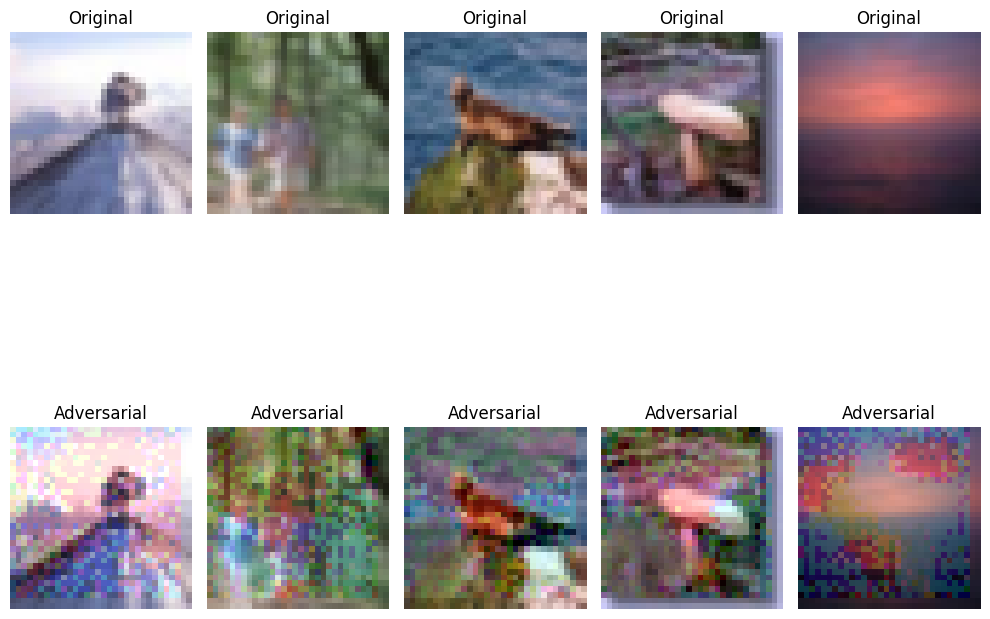

In [10]:
# Visualization function
def visualize_examples(x_test, x_adv, num_examples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(x_adv[i])
        plt.title("Adversarial")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize examples
visualize_examples(x_test_subset, x_test_pgd)